<a href="https://colab.research.google.com/github/Panixara/Analysis-of-Drug-situation-in-Thailand/blob/main/DSI314_Cleaned_code_for_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DSI314 Project: Analysis of Drug problem in Thailand**

# **Data Collection**
เก็บข้อมูลจากแหล่งต่าง ๆ เพื่อให้ได้ข้อมูลที่จำเป็นต้องใช้ในการวิเคราะห์ข้อมูลจาก

> สำนักงานสถิติแห่งชาติ (สสช.)

> สำนักงานคณะกรรมการป้องกันและปราบปรามยาเสพติด (ป.ป.ส.)

> กระทรวงสาธารณสุข

> กรมการปกครอง













### **Import libraries and dataset**

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as mticker
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import warnings
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
import seaborn as sns
import plotly.express as px
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
warnings.filterwarnings('ignore')

treatment = pd.read_excel('บำบัดรักษายาเสพติด 60-64(1).xlsx')
suspect = pd.read_excel('จำนวนผู้ต้องหาคดีเสพยาเสพติด ปี 60-64.xlsx')

# **Data Cleaning**
ตรวจสอบข้อมูลที่ดึงมาเพื่อคัดเลือกเฉพาะคอลัมน์ที่จำเป็นต้องใช้และตัดคอลัมน์ที่ไม่มีความจำเป็นออก

In [ ]:
if 'รหัสจังหวัด' in treatment.columns:
    treatment = treatment.drop(columns=['รหัสจังหวัด'])
treatment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ชื่อจังหวัด  77 non-null     object
 1   2560         77 non-null     int64 
 2   2561         77 non-null     int64 
 3   2562         77 non-null     int64 
 4   2563         77 non-null     int64 
 5   2564         77 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 3.7+ KB


# **Exploratory Data Analysis**
หารูปแบบของชุดข้อมูลต่าง ๆ ศึกษาแนวโน้มที่เกิดขึ้นในแต่ละปีเพื่อใช้ทำนายค่าที่อาจเป็นไปได้ในอนาคต

##**Finding the optimal model**
เปรียบเทียบผลลัพธ์ของโมเดลทำนาย 5 แบบ ได้แก่ Moving Average, ARIMA, Holt-Winters, และโมเดล Bootstrap ระดับความเชื่อมั่น 95% และ 99% โดยใช้ข้อมูล treatment ในการเลือกโมเดลที่เหมาะสมที่สุดสำหรับทำนายจำนวนผู้บำบัดในอนาคต โดยโมเดลที่มีความคลาดเคลื่อนน้อยที่สุดจะถือว่าแม่นยำที่สุด

**Split the training and testing data**

In [ ]:
treatment.columns = treatment.columns.astype(str)

train_data = treatment[['ชื่อจังหวัด', '2560', '2561', '2562', '2563']]
test_data = treatment[['ชื่อจังหวัด', '2564']]
print(train_data)

      ชื่อจังหวัด   2560   2561   2562  2563
0          กระบี่    723   1163   1259   980
1   กรุงเทพมหานคร  12406  13574  14219  9526
2       กาญจนบุรี   1876   2501   3089  2573
3       กาฬสินธุ์   3077   2370   2800  1934
4       กำแพงเพชร   1491   1495   1508  1343
..            ...    ...    ...    ...   ...
72     อำนาจเจริญ   1336   1692   2023  1916
73       อุดรธานี   4963   5334   5547  5174
74      อุตรดิตถ์   1994   1743   1669  1612
75      อุทัยธานี    730    695    734   673
76    อุบลราชธานี   6586   7100   7884  5813

[77 rows x 5 columns]


In [ ]:
print(test_data)

      ชื่อจังหวัด  2564
0          กระบี่   664
1   กรุงเทพมหานคร  5162
2       กาญจนบุรี  1489
3       กาฬสินธุ์  2265
4       กำแพงเพชร  1263
..            ...   ...
72     อำนาจเจริญ  1709
73       อุดรธานี  5629
74      อุตรดิตถ์  1620
75      อุทัยธานี   979
76    อุบลราชธานี  6547

[77 rows x 2 columns]


**Moving Average**

In [ ]:
#Moving average
treatment.columns = treatment.columns.astype(str)

train_sums = treatment[['2560', '2561', '2562', '2563']].sum()

forecast_2564 = train_sums.mean()

actual_2564_sum = treatment['2564'].sum()

print("Sum of each year (2560-2563):\n", train_sums)
print("\nMoving Average for 2564:", forecast_2564)
print("Actual sum for 2564:", actual_2564_sum)

difference = actual_2564_sum - forecast_2564
print("\nDifference between actual 2564 and moving average 2564:", difference)

Sum of each year (2560-2563):
 2560    181448
2561    208050
2562    229680
2563    190395
dtype: int64

Moving Average for 2564: 202393.25
Actual sum for 2564: 168569

Difference between actual 2564 and moving average 2564: -33824.25


**ARIMA**

In [ ]:
#ARIMA
treatment.columns = treatment.columns.astype(str)

yearly_sums = treatment[['2560', '2561', '2562', '2563']].sum()
print("Yearly sums from 2560 to 2563:\n", yearly_sums)

time_series = yearly_sums.values

model = ARIMA(time_series, order=(1, 1, 1))
model_fit = model.fit()

forecast_2564 = model_fit.forecast()[0]
print("\nARIMA sum for 2564:", forecast_2564)

actual_2564_sum = treatment['2564'].sum()
print("Actual sum for 2564:", actual_2564_sum)

difference_ari = actual_2564_sum - forecast_2564
print("\nDifference between actual 2564 and ARIMA 2564:", difference_ari)

Yearly sums from 2560 to 2563:
 2560    181448
2561    208050
2562    229680
2563    190395
dtype: int64

ARIMA sum for 2564: 185601.6219854767
Actual sum for 2564: 168569

Difference between actual 2564 and ARIMA 2564: -17032.621985476697


**Holt-Winters**

In [ ]:
#Exponential Smoothing model (Holt-Winters)
yearly_sums = treatment[['2560', '2561', '2562', '2563']].sum()
print("Yearly sums from 2560 to 2563:\n", yearly_sums)

holt_winters_model = ExponentialSmoothing(time_series, trend='add').fit()

holt_winters_forecast_2564 = holt_winters_model.forecast()[0]
print("\nHolt-Winters forecast for 2564:", holt_winters_forecast_2564)
actual_2564_sum = treatment['2564'].sum()
print("Actual sum for 2564:", actual_2564_sum)

difference_hw = actual_2564_sum - holt_winters_forecast_2564
print("\nDifference between actual 2564 and Holt-Winters forecast 2564:", difference_hw)

Yearly sums from 2560 to 2563:
 2560    181448
2561    208050
2562    229680
2563    190395
dtype: int64

Holt-Winters forecast for 2564: 211574.50833335824
Actual sum for 2564: 168569

Difference between actual 2564 and Holt-Winters forecast 2564: -43005.508333358244


**Bootstrapped with 95% confidence interval**

In [ ]:
#Bootstrapped with 95% confidence interval
yearly_sums = treatment[['2560', '2561', '2562', '2563']].sum()
print("Yearly sums from 2560 to 2563:\n", yearly_sums)

actual_2564_sum = treatment['2564'].sum()
print("\nActual sum for 2564:", actual_2564_sum)

n_bootstrap_samples = 100
bootstrap_forecasts = []

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for _ in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(yearly_sums, size=len(yearly_sums), replace=True)
    try:
        model = ARIMA(bootstrap_sample, order=(1, 1, 1))
        model_fit = model.fit()
        forecast_2564 = model_fit.forecast()[0]
    except:
        continue
    bootstrap_forecasts.append(forecast_2564)

if bootstrap_forecasts:
    mean_forecast = np.mean(bootstrap_forecasts)
    lower_bound = np.percentile(bootstrap_forecasts, 2.5)
    upper_bound = np.percentile(bootstrap_forecasts, 97.5)

    print("Bootstrapped forecast for 2564:", mean_forecast)
    print("95% Confidence Interval:", (lower_bound, upper_bound))

    difference_95 = actual_2564_sum - mean_forecast
    print("\nDifference between actual 2564 and bootstrapped forecast:", difference_95)
else:
    print("\nARIMA failed on all bootstrap samples; consider using a different model.")

Yearly sums from 2560 to 2563:
 2560    181448
2561    208050
2562    229680
2563    190395
dtype: int64

Actual sum for 2564: 168569
Bootstrapped forecast for 2564: 209024.8908315472
95% Confidence Interval: (176450.69257705996, 242870.14368118663)

Difference between actual 2564 and bootstrapped forecast: -40455.89083154721


**Bootstrapped with 99% confidence interval**

In [ ]:
#Bootstrapped with 99% confidence interval
yearly_sums = treatment[['2560', '2561', '2562', '2563']].sum()
print("Yearly sums from 2560 to 2563:\n", yearly_sums)

actual_2564_sum = treatment['2564'].sum()
print("\nActual sum for 2564:", actual_2564_sum)

n_bootstrap_samples = 100
bootstrap_forecasts = []

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for _ in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(yearly_sums, size=len(yearly_sums), replace=True)
    try:
        model = ARIMA(bootstrap_sample, order=(1, 1, 1))
        model_fit = model.fit()
        forecast_2564 = model_fit.forecast()[0]
    except:
        continue
    bootstrap_forecasts.append(forecast_2564)

if bootstrap_forecasts:
    mean_forecast = np.mean(bootstrap_forecasts)
    lower_bound = np.percentile(bootstrap_forecasts, 0.5)
    upper_bound = np.percentile(bootstrap_forecasts, 99.5)

    print("Bootstrapped forecast for 2564:", mean_forecast)
    print("99% Confidence Interval:", (lower_bound, upper_bound))

    difference_99 = actual_2564_sum - mean_forecast
    print("\nDifference between actual 2564 and bootstrapped forecast:", difference_99)
else:
    print("\nARIMA failed on all bootstrap samples; consider using a different model.")

Yearly sums from 2560 to 2563:
 2560    181448
2561    208050
2562    229680
2563    190395
dtype: int64

Actual sum for 2564: 168569
Bootstrapped forecast for 2564: 203189.0076770985
99% Confidence Interval: (173025.80293985698, 242576.29594253429)

Difference between actual 2564 and bootstrapped forecast: -34620.0076770985


**Graph Plotting**

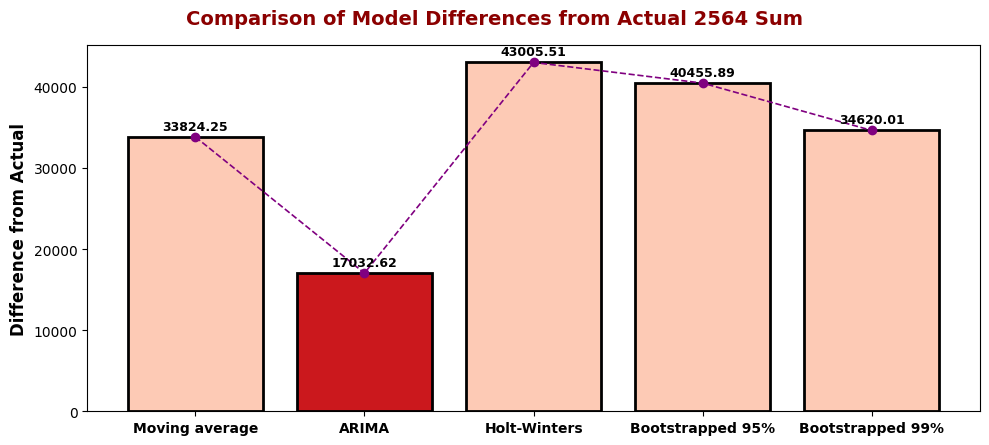

In [ ]:
data = {
    'Model': ['Moving average', 'ARIMA', 'Holt-Winters', 'Bootstrapped 95%', 'Bootstrapped 99%'],
    'Difference': [difference*(-1), difference_ari*(-1), difference_hw*(-1), difference_95*(-1), difference_99*(-1)]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

fig, ax = plt.subplots(figsize=(10, 4.5))

values = df['Difference']
labels = df.index

cmap = plt.get_cmap('Reds_r')

num_models = len(labels) - 1  # exclude ARIMA
norm = plt.Normalize(vmin=0, vmax=num_models)

colors = [cmap(norm(i)) if label == 'ARIMA' else cmap(0.8) for i, label in enumerate(labels)]

#Bar chart
rects = ax.bar(labels, values, color=colors, edgecolor='black', linewidth=2.0)
ax.plot(labels, values, '--o', linewidth=1.2, color='purple')

ax.set_ylabel('Difference from Actual', fontsize=12, fontweight='bold', color='black')
ax.set_xticklabels(labels, fontsize=10, fontweight='bold')

fig.suptitle("Comparison of Model Differences from Actual 2564 Sum", fontsize=14, fontweight='bold', color='darkred')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f'{height:.2f}',
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom',
            weight='bold', size=9, color='black'
        )

autolabel(rects)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

จากข้อมูลในกราฟ โมเดล **ARIMA** เป็นโมเดลที่แม่นยำที่สุด เนื่องจากมีค่าผลต่างจากค่าจริงต่ำที่สุด (-17,032.62) และเหมาะสำหรับการทำนายข้อมูลเชิงเวลาในกรณีนี้ ผู้จัดทำจึงได้ใช้ ARIMA ในการพยากรณ์จำนวน treatment และ suspect ต่อไป

## **Forecast**

### **ARIMA**
คาดการณ์จำนวนผู้เข้ารับการบำบัดและจำนวนผู้ต้องหาคดียาเสพติดในช่วง 5 ปีข้างหน้า (พ.ศ. 2565-2569)
  * แบ่งข้อมูลเป็นช่วง:
    * ใช้ข้อมูลจากปี พ.ศ. 2560-2564 เพื่อทำนายจำนวนคนในปี พ.ศ. 2565
    * ใช้ข้อมูลจากปี พ.ศ. 2560-2565 เพื่อทำนายจำนวนคนในปี พ.ศ. 2566
    * ทำเช่นนี้ไปเรื่อย ๆ จนถึงปี พ.ศ. 2569
  * ใช้ ARIMA (1, 1, 1) เพื่อวิเคราะห์ข้อมูลในอดีตและทำนายผลในอนาคต

In [ ]:
suspect.columns = suspect.columns.astype(str)
treatment.columns = treatment.columns.astype(str)

In [ ]:
yearly_sums = suspect[['2560', '2561', '2562', '2563', '2564']].sum()
time_series = yearly_sums.values

arima_order = (1, 1, 1)

years_to_predict = 5  # 2565 to 2569

forecasts_suspect = []

for year in range(years_to_predict):
    model = ARIMA(time_series, order=arima_order)
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=1)[-1]
    forecasts_suspect.append(forecast)

    time_series = list(time_series) + [forecast]

    print(f"ARIMA forecast suspect for 256{5 + year}: {forecast}")
print("\nForecasts from 2565 to 2569:", forecasts_suspect)

ARIMA forecast suspect for 2565: 265814.40572369716
ARIMA forecast suspect for 2566: 265814.4344714644
ARIMA forecast suspect for 2567: 291844.0884053127
ARIMA forecast suspect for 2568: 319419.8278871897
ARIMA forecast suspect for 2569: 345963.137586671

Forecasts from 2565 to 2569: [265814.40572369716, 265814.4344714644, 291844.0884053127, 319419.8278871897, 345963.137586671]


In [ ]:
yearly_sums = treatment[['2560', '2561', '2562', '2563', '2564']].sum()
time_series = yearly_sums.values

arima_order = (1, 1, 1)

years_to_predict = 5  # 2565 to 2569

forecasts_treatment = []

for year in range(years_to_predict):
    model = ARIMA(time_series, order=arima_order)
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=1)[-1]
    forecasts_treatment.append(forecast)

    time_series = list(time_series) + [forecast]

    print(f"ARIMA forecast treatment for 256{5 + year}: {forecast}")
print("\nForecasts from 2565 to 2569:", forecasts_treatment)

ARIMA forecast treatment for 2565: 164857.36555068294
ARIMA forecast treatment for 2566: 160674.27934944446
ARIMA forecast treatment for 2567: 157801.705523862
ARIMA forecast treatment for 2568: 157803.30911998427
ARIMA forecast treatment for 2569: 157801.06496006408

Forecasts from 2565 to 2569: [164857.36555068294, 160674.27934944446, 157801.705523862, 157803.30911998427, 157801.06496006408]


In [ ]:
ขmerged_df = pd.merge(suspect, treatment, on='ชื่อจังหวัด', how='outer')
merged_df.columns

Index(['ชื่อจังหวัด', '2560_x', '2561_x', '2562_x', '2563_x', '2564_x',
       '2560_y', '2561_y', '2562_y', '2563_y', '2564_y'],
      dtype='object')

In [ ]:
# Rename columns with suffixes to indicate the source of data
merged_df.rename(columns={
    '2560_x': '2560_suspect',
    '2561_x': '2561_suspect',
    '2562_x': '2562_suspect',
    '2563_x': '2563_suspect',
    '2564_x': '2564_suspect',
    '2560_y': '2560_treatment',
    '2561_y': '2561_treatment',
    '2562_y': '2562_treatment',
    '2563_y': '2563_treatment',
    '2564_y': '2564_treatment',
}, inplace=True)
merged_df

,ชื่อจังหวัด,2560_suspect,2561_suspect,2562_suspect,2563_suspect,2564_suspect,2560_treatment,2561_treatment,2562_treatment,2563_treatment,2564_treatment
0,กระบี่,189,253,500,800,1637,723,1163,1259,980,664
1,กรุงเทพมหานคร,12371,17131,15458,9754,9797,12406,13574,14219,9526,5162
2,กาญจนบุรี,1412,2227,2092,1309,1246,1876,2501,3089,2573,1489
3,กาฬสินธุ์,496,681,810,1697,4197,3077,2370,2800,1934,2265
4,กำแพงเพชร,521,1269,2208,1193,860,1491,1495,1508,1343,1263
...,...,...,...,...,...,...,...,...,...,...,...
72,เพชรบุรี,741,1244,1395,1397,1281,1580,1596,1934,1496,1032
73,เพชรบูรณ์,715,1762,1378,886,2517,2601,2634,3364,3406,2972
74,เลย,706,867,797,879,2596,1358,1376,1519,1697,2120
75,แพร่,1619,1843,2015,2105,3069,2105,1919,2081,1895,1910


In [ ]:
treatment_sum_2560 = merged_df['2560_treatment'].sum()
treatment_sum_2561 = merged_df['2561_treatment'].sum()
treatment_sum_2562 = merged_df['2562_treatment'].sum()
treatment_sum_2563 = merged_df['2563_treatment'].sum()
treatment_sum_2564 = merged_df['2564_treatment'].sum()

print("Sum of treatment for each year:")
print("2560:", treatment_sum_2560)
print("2561:", treatment_sum_2561)
print("2562:", treatment_sum_2562)
print("2563:", treatment_sum_2563)
print("2564:", treatment_sum_2564)


# Sum of 'suspect' for each year
suspect_sum_2560 = merged_df['2560_suspect'].sum()
suspect_sum_2561 = merged_df['2561_suspect'].sum()
suspect_sum_2562 = merged_df['2562_suspect'].sum()
suspect_sum_2563 = merged_df['2563_suspect'].sum()
suspect_sum_2564 = merged_df['2564_suspect'].sum()

print("\nSum of suspect for each year:")
print("2560:", suspect_sum_2560)
print("2561:", suspect_sum_2561)
print("2562:", suspect_sum_2562)
print("2563:", suspect_sum_2563)
print("2564:", suspect_sum_2564)

Sum of treatment for each year:
2560: 181448
2561: 208050
2562: 229680
2563: 190395
2564: 168569

Sum of suspect for each year:
2560: 93895
2561: 150049
2562: 179823
2563: 141761
2564: 235803


**Graph**

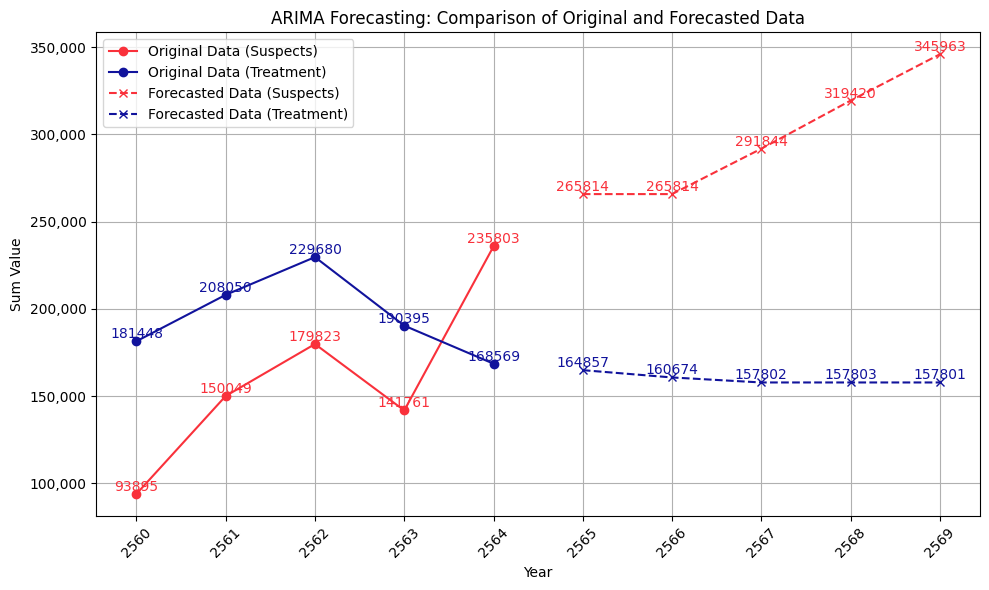

In [ ]:
years = ['2560', '2561', '2562', '2563', '2564']
forecast_years = ['2565', '2566', '2567', '2568', '2569']

# Original data for each dataset
original_data_1 = [93895, 150049, 179823, 141761, 235803]
original_data_2 = [181448, 208050, 229680, 190395, 168569]

# Forecasted data for each dataset
forecasted_data_1 = [265814, 265814, 291844, 319420, 345963]
forecasted_data_2 = [164857, 160674, 157802, 157803, 157801]

# Plot both original datasets
plt.figure(figsize=(10, 6))
plt.plot(years, original_data_1, label="Original Data (Suspects)", marker='o', linestyle='-', color='#f9313b')
plt.plot(years, original_data_2, label="Original Data (Treatment)", marker='o', linestyle='-', color='#11139c')

# Plot both forecasted datasets
plt.plot(forecast_years, forecasted_data_1, label="Forecasted Data (Suspects)", marker='x', linestyle='--', color='#f9313b')
plt.plot(forecast_years, forecasted_data_2, label="Forecasted Data (Treatment)", marker='x', linestyle='--', color='#11139c')

# Add labels and title
plt.title("ARIMA Forecasting: Comparison of Original and Forecasted Data")
plt.xlabel("Year")
plt.ylabel("Sum Value")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Annotate original data points
for i, value in enumerate(original_data_1):
    plt.text(years[i], value, f'{value:.0f}', color='#f9313b', fontsize=10, ha='center', va='bottom')

for i, value in enumerate(original_data_2):
    plt.text(years[i], value, f'{value:.0f}', color='#11139c', fontsize=10, ha='center', va='bottom')

# Annotate forecasted data points
for i, forecast in enumerate(forecasted_data_1):
    plt.text(forecast_years[i], forecast, f'{forecast:.0f}', color='#f9313b', fontsize=10, ha='center', va='bottom')

for i, forecast in enumerate(forecasted_data_2):
    plt.text(forecast_years[i], forecast, f'{forecast:.0f}', color='#11139c', fontsize=10, ha='center', va='bottom')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
# Display the plot
plt.tight_layout()
plt.show()

**จากการวิเคราะห์กราฟข้อมูลพบว่า**

* **เส้นสีน้ำเงิน (treatment)** ซึ่งแสดงจำนวนผู้เข้ารับการบำบัด มีแนวโน้มลดลงเรื่อย ๆ และเริ่มคงที่ในช่วงปี พ.ศ. 2565-2569 สะท้อนถึงข้อจำกัดของระบบบำบัด เช่น จำนวนเตียงที่ไม่เพียงพอ หรือระยะเวลาบำบัดที่ยาวนาน รวมถึงปัญหาการกลับไปใช้ยาเสพติดอีก (relapse) ซึ่งลดทอนความสามารถในการรองรับผู้บำบัดรายใหม่ได้อย่างมีประสิทธิภาพ
* **เส้นสีแดง (suspect)** ซึ่งแสดงจำนวนผู้ต้องสงสัยในคดียาเสพติด มีแนวโน้มเพิ่มสูงขึ้นอย่างชัดเจน สะท้อนสถานการณ์ที่ท้าทายในการควบคุมอาชญากรรมยาเสพติด เช่น การขยายตัวของเครือข่ายผู้ลักลอบ และการเปลี่ยนแปลงรูปแบบการกระทำผิด


แนวโน้มที่สวนทางกันนี้เน้นย้ำถึงความจำเป็นในการวางนโยบายที่สมดุลระหว่างการเพิ่มศักยภาพของระบบบำบัดและการบังคับใช้กฎหมาย โดยเฉพาะการแก้ไขปัญหายาเสพติดในเชิงโครงสร้างที่ครอบคลุมทั้งด้านสุขภาพ การศึกษา และกระบวนการยุติธรรม

### **Linear regression**
เนื่องจาก ARIMA เป็นการพยากรณ์อนาคตโดยอิงจากข้อมูลชุดเดียว ผู้จัดทำจึงต้องการยืนยันความน่าเชื่อถือของผลลัพธ์ที่ได้ โดยทำการวิเคราะห์ ค่า correlation ระหว่างชุดข้อมูลต่าง ๆ พบว่าข้อมูล treatment และ suspect มีความสัมพันธ์กันมากที่สุด ผู้จัดทำจึงเลือกใช้ข้อมูลทั้งสองชุดนี้ในโมเดล

สำหรับการพยากรณ์ด้วย Linear Regression จะใช้ผลลัพธ์การพยากรณ์ treatment จาก ARIMA เป็นตัวแปรสำคัญ เพื่อวิเคราะห์ว่าประเทศไทยควรสามารถรองรับผู้เข้ารับการบำบัด (treatment) ได้เท่าใดภายในปี พ.ศ. 2569

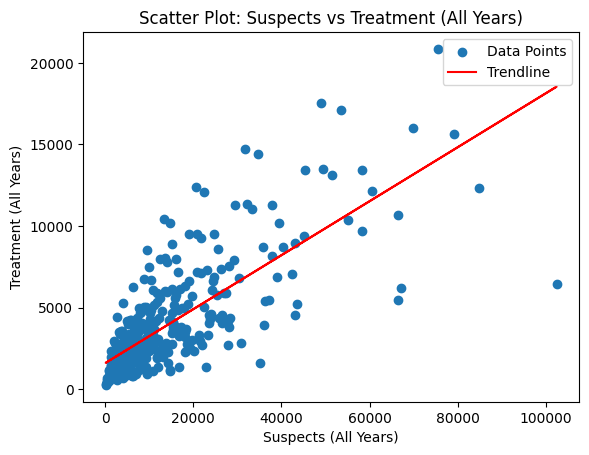

Overall RMSE: 2075.4498321013734
Overall Correlation: 0.7611751219143057


In [ ]:
x = merged_df[['2565_suspect', '2566_suspect', '2567_suspect', '2568_suspect', '2569_suspect']].values.flatten()
y = merged_df[['2565_treatment', '2566_treatment', '2567_treatment', '2568_treatment', '2569_treatment']].values.flatten()

# Scatter plot
plt.scatter(x, y, label='Data Points')
plt.xlabel('Suspects (All Years)')
plt.ylabel('Treatment (All Years)')
plt.title('Scatter Plot: Suspects vs Treatment (All Years)')

# Trendline
coefficients = np.polyfit(x, y, 1)  # Linear fit
trendline = np.poly1d(coefficients)
plt.plot(x, trendline(x), color='red', label='Trendline')
prediceted_y = trendline(x)

plt.legend()
plt.show()

rmse = np.sqrt(np.mean((y - prediceted_y) ** 2))
print(f"Overall RMSE: {rmse}")
# Correlation (for flattened arrays)
correlation = np.corrcoef(x, y)[0, 1]
print(f"Overall Correlation: {correlation}")

ใช้ Scatterplot เพื่อตรวจสอบว่าข้อมูลจากชุด treatment และ suspect มีการเกาะกลุ่มกันมากพอที่จะนำไปใช้ใน Linear Regression ได้หรือไม่ เป็นการยืนยันเพิ่มเติมอีกครั้ง

In [ ]:
X = merged_df[['2565_suspect', '2566_suspect', '2567_suspect', '2568_suspect', '2569_suspect']].values
y = merged_df[['2565_treatment', '2566_treatment', '2567_treatment', '2568_treatment', '2569_treatment']].values

model = LinearRegression()
model.fit(X, y)

future_suspects = [[363136.62, 559230.41, 861214.88, 1326270.93, 2042457.25]]
predicted_treatment = model.predict(future_suspects)
print(f"Predicted treatment for entire country: {predicted_treatment}")

Predicted treatment for entire country: [[156728.89685155 186507.37908578 221943.7642338  264113.02224535
  314294.50967016]]


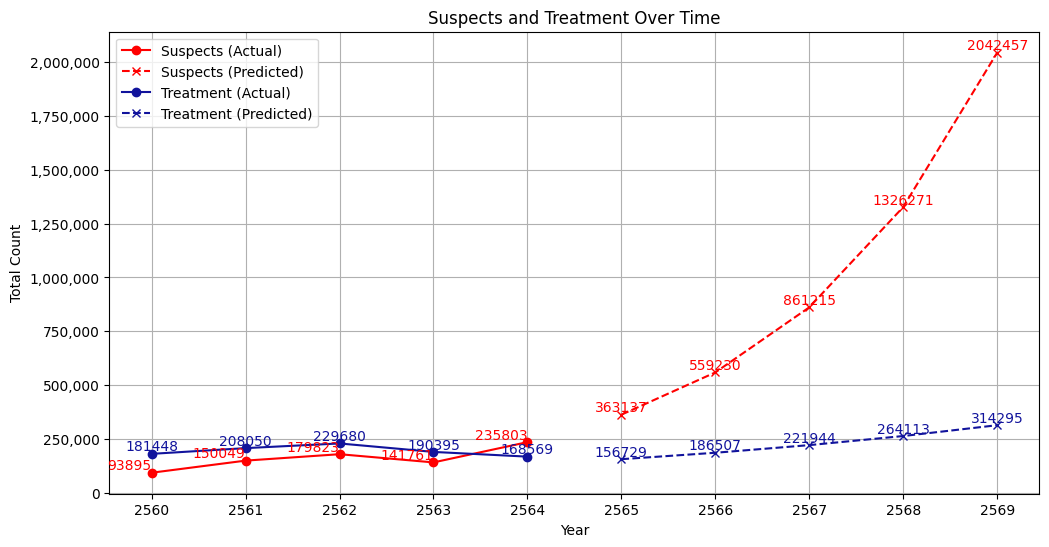

In [ ]:
years = ['2560', '2561', '2562', '2563', '2564', '2565', '2566', '2567', '2568', '2569']
suspect_data = merged_df[[col for col in merged_df.columns if 'suspect' in col and col.startswith('2')]].sum().values
treatment_data = merged_df[[col for col in merged_df.columns if 'treatment' in col and col.startswith('2')]].sum().values

plt.figure(figsize=(12, 6))

# Plot Suspects (Actual and Predicted)
plt.plot(years[:5], suspect_data[:5], marker='o', linestyle='-', label='Suspects (Actual)', color='r')
plt.plot(years[5:], suspect_data[5:10], marker='x', linestyle='--', label='Suspects (Predicted)', color='r')

# Plot Treatment (Actual and Predicted)
plt.plot(years[:5], treatment_data[:5], marker='o', linestyle='-', label='Treatment (Actual)', color='#11139c')
plt.plot(years[5:], predicted_treatment[0], marker='x', linestyle='--', label='Treatment (Predicted)', color='#11139c')

# Add text for Suspect (Actual and Predicted)
for i, value in enumerate(suspect_data[:5]):
    plt.text(years[i], value, f'{value:.0f}', color='r', fontsize=10, ha='right', va='bottom')
for i, value in enumerate(suspect_data[5:]):
    # Ensure the index doesn't exceed the length of 'years'
    if i + 5 < len(years):
        plt.text(years[i + 5], value, f'{value:.0f}', color='r', fontsize=10, ha='center', va='bottom')

# Add text for Treatment (Actual and Predicted)
for i, forecast in enumerate(treatment_data[:5]):  # Only for years 2560-2564
    plt.text(years[i], forecast, f'{forecast:.0f}', color='#11139c', fontsize=10, ha='center', va='bottom')
for i, forecast in enumerate(predicted_treatment[0]):  # For predicted years 2565-2569
    plt.text(years[i + 5], forecast, f'{forecast:.0f}', color='#11139c', fontsize=10, ha='center', va='bottom')

# Final plot adjustments
plt.title('Suspects and Treatment Over Time')
plt.xlabel('Year')
plt.ylabel('Total Count')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.grid(True)
plt.show()


ผลลัพธ์แสดงให้เห็นว่าเมื่อจำนวนผู้ต้องกาคดียาเสพติด

### **Simple Growth Model**
หลังจากได้ผลลัพธ์ว่าภายในปี พ.ศ. 2569 ประเทศไทยควรสามารถรองรับผู้เข้ารับการบำบัดได้จำนวนเท่าใดแล้ว ผู้จัดทำจะใช้ Simple Growth Model เพื่อกระจายและพยากรณ์ความสามารถในการรองรับผู้เข้าบำบัดรายจังหวัดภายในปีเดียวกัน

  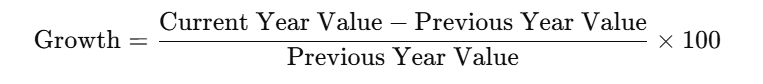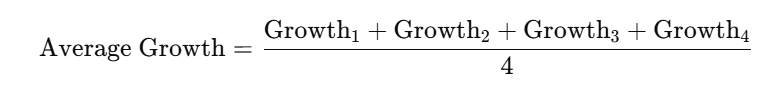

**หา growth rate ของ treatment และ suspect**

In [ ]:
#treatment
treatment_growth1 = ((merged_df['2561_treatment'] - merged_df['2560_treatment'])/merged_df['2560_treatment'])*100
treatment_growth2 = ((merged_df['2562_treatment'] - merged_df['2561_treatment'])/merged_df['2561_treatment'])*100
treatment_growth3 = ((merged_df['2563_treatment'] - merged_df['2562_treatment'])/merged_df['2562_treatment'])*100
treatment_growth4 = ((merged_df['2564_treatment'] - merged_df['2563_treatment'])/merged_df['2563_treatment'])*100

growth_df_treatment = pd.DataFrame({
    'Province': merged_df['ชื่อจังหวัด'],
    '2560_Treatment': merged_df['2560_treatment'],
    '2561_Treatment': merged_df['2561_treatment'],
    '2562_Treatment': merged_df['2562_treatment'],
    '2563_Treatment': merged_df['2563_treatment'],
    '2564_Treatment': merged_df['2564_treatment'],
    'Growth_2560_to_2561': treatment_growth1,
    'Growth_2561_to_2562': treatment_growth2,
    'Growth_2562_to_2563': treatment_growth3,
    'Growth_2563_to_2564': treatment_growth4,
})

# Calculate average growt้h
growth_df_treatment['Average_Growth'] = (treatment_growth1 + treatment_growth2 + treatment_growth3 + treatment_growth4) / 4
#mean
average_growth_mean1 = growth_df_treatment['Growth_2560_to_2561'].mean()
average_growth_mean2 = growth_df_treatment['Growth_2561_to_2562'].mean()
average_growth_mean3 = growth_df_treatment['Growth_2562_to_2563'].mean()
average_growth_mean4 = growth_df_treatment['Growth_2563_to_2564'].mean()
average_growth_mean = (average_growth_mean1+average_growth_mean2+average_growth_mean3+average_growth_mean4)/4
print("Average Growth Rate for All Provinces:", average_growth_mean)


growth_df_treatment

Average Growth Rate for All Provinces: 1.9266021868487124


,Province,2560_Treatment,2561_Treatment,2562_Treatment,2563_Treatment,2564_Treatment,Growth_2560_to_2561,Growth_2561_to_2562,Growth_2562_to_2563,Growth_2563_to_2564,Average_Growth
0,กระบี่,723,1163,1259,980,664,60.857538,8.254514,-22.160445,-32.244898,3.676677
1,กรุงเทพมหานคร,12406,13574,14219,9526,5162,9.414799,4.751731,-33.005134,-45.811463,-16.162517
2,กาญจนบุรี,1876,2501,3089,2573,1489,33.315565,23.510596,-16.704435,-42.129810,-0.502021
3,กาฬสินธุ์,3077,2370,2800,1934,2265,-22.976926,18.143460,-30.928571,17.114788,-4.661812
4,กำแพงเพชร,1491,1495,1508,1343,1263,0.268276,0.869565,-10.941645,-5.956813,-3.940154
...,...,...,...,...,...,...,...,...,...,...,...
72,เพชรบุรี,1580,1596,1934,1496,1032,1.012658,21.177945,-22.647363,-31.016043,-7.868201
73,เพชรบูรณ์,2601,2634,3364,3406,2972,1.268743,27.714503,1.248514,-12.742220,4.372385
74,เลย,1358,1376,1519,1697,2120,1.325479,10.392442,11.718236,24.926341,12.090624
75,แพร่,2105,1919,2081,1895,1910,-8.836105,8.441897,-8.938011,0.791557,-2.135165


In [ ]:
#suspect
suspect_growth1 = ((merged_df['2561_suspect'] - merged_df['2560_suspect'])/merged_df['2560_suspect'])*100
suspect_growth2 = ((merged_df['2562_suspect'] - merged_df['2561_suspect'])/merged_df['2561_suspect'])*100
suspect_growth3 = ((merged_df['2563_suspect'] - merged_df['2562_suspect'])/merged_df['2562_suspect'])*100
suspect_growth4 = ((merged_df['2564_suspect'] - merged_df['2563_suspect'])/merged_df['2563_suspect'])*100

growth_df_suspect = pd.DataFrame({
    'Province': merged_df['ชื่อจังหวัด'],
    '2560_suspect': merged_df['2560_suspect'],
    '2561_suspect': merged_df['2561_suspect'],
    '2562_suspect': merged_df['2562_suspect'],
    '2563_suspect': merged_df['2563_suspect'],
    '2564_suspect': merged_df['2564_suspect'],
    'Growth_2560_to_2561': suspect_growth1,
    'Growth_2561_to_2562': suspect_growth2,
    'Growth_2562_to_2563': suspect_growth3,
    'Growth_2563_to_2564': suspect_growth4,
})

# Calculate average growth
growth_df_suspect['Average_Growth'] = (suspect_growth1 + suspect_growth2 + suspect_growth3 + suspect_growth4) / 4

average_growth_mean = growth_df_suspect['Average_Growth'].mean()
print("Average Growth Rate for All Provinces:", average_growth_mean)


growth_df_suspect

Average Growth Rate for All Provinces: 54.09264084290196


,Province,2560_suspect,2561_suspect,2562_suspect,2563_suspect,2564_suspect,Growth_2560_to_2561,Growth_2561_to_2562,Growth_2562_to_2563,Growth_2563_to_2564,Average_Growth
0,กระบี่,189,253,500,800,1637,33.862434,97.628458,60.000000,104.625000,74.028973
1,กรุงเทพมหานคร,12371,17131,15458,9754,9797,38.477084,-9.765921,-36.899987,0.440845,-1.936995
2,กาญจนบุรี,1412,2227,2092,1309,1246,57.719547,-6.061967,-37.428298,-4.812834,2.354112
3,กาฬสินธุ์,496,681,810,1697,4197,37.298387,18.942731,109.506173,147.318798,78.266522
4,กำแพงเพชร,521,1269,2208,1193,860,143.570058,73.995272,-45.969203,-27.912825,35.920825
...,...,...,...,...,...,...,...,...,...,...,...
72,เพชรบุรี,741,1244,1395,1397,1281,67.881242,12.138264,0.143369,-8.303508,17.964842
73,เพชรบูรณ์,715,1762,1378,886,2517,146.433566,-21.793417,-35.703919,184.085779,68.255502
74,เลย,706,867,797,879,2596,22.804533,-8.073818,10.288582,195.335609,55.088726
75,แพร่,1619,1843,2015,2105,3069,13.835701,9.332610,4.466501,45.795724,18.357634


In [ ]:
province_max_treatment = growth_df_treatment.loc[growth_df_treatment['Average_Growth'].idxmax()]
print(f"Province with highest average growth (treatment): {province_max_treatment['Province']}, Growth: {province_max_treatment['Average_Growth']}")

province_max_suspect = growth_df_suspect.loc[growth_df_suspect['Average_Growth'].idxmax()]
print(f"Province with highest average growth (suspect): {province_max_suspect['Province']}, Growth: {province_max_suspect['Average_Growth']}")

Province with highest average growth (treatment): หนองบัวลำภู, Growth: 20.995518147285306
Province with highest average growth (suspect): หนองบัวลำภู, Growth: 270.6602823210914


In [ ]:
# Display top 10 provinces based on average growth for suspect data
top_10_provinces_suspect = growth_df_suspect.sort_values(by='Average_Growth', ascending=False).head(10)
print("\nTop 10 Provinces with Highest Average Growth (Suspect):")
print(top_10_provinces_suspect[['Province', 'Average_Growth']])

# Display top 10 provinces based on average growth for treatment data
top_10_provinces_treatment = growth_df_treatment.sort_values(by='Average_Growth', ascending=False).head(10)
print("Top 10 Provinces with Highest Average Growth (Treatment):")
print(top_10_provinces_treatment[['Province', 'Average_Growth']])


Top 10 Provinces with Highest Average Growth (Suspect):
       Province  Average_Growth
63  หนองบัวลำภู      270.660282
55      สระบุรี      216.723229
34       พิจิตร      137.051601
65     อุดรธานี      113.115383
36       ภูเก็ต      111.786079
48     ศรีสะเกษ      109.037220
25    บุรีรัมย์      106.096773
66    อุตรดิตถ์      103.884042
20    นครสวรรค์      101.994922
21      นนทบุรี      101.420636
Top 10 Provinces with Highest Average Growth (Treatment):
           Province  Average_Growth
63      หนองบัวลำภู       20.995518
10          ชัยภูมิ       18.116504
27  ประจวบคีรีขันธ์       17.276060
51             สตูล       16.092497
60         สุรินทร์       15.044748
38         มุกดาหาร       14.447300
61          สุโขทัย       12.754232
9            ชัยนาท       12.471559
74              เลย       12.090624
22         นราธิวาส       11.861911


**Graph**

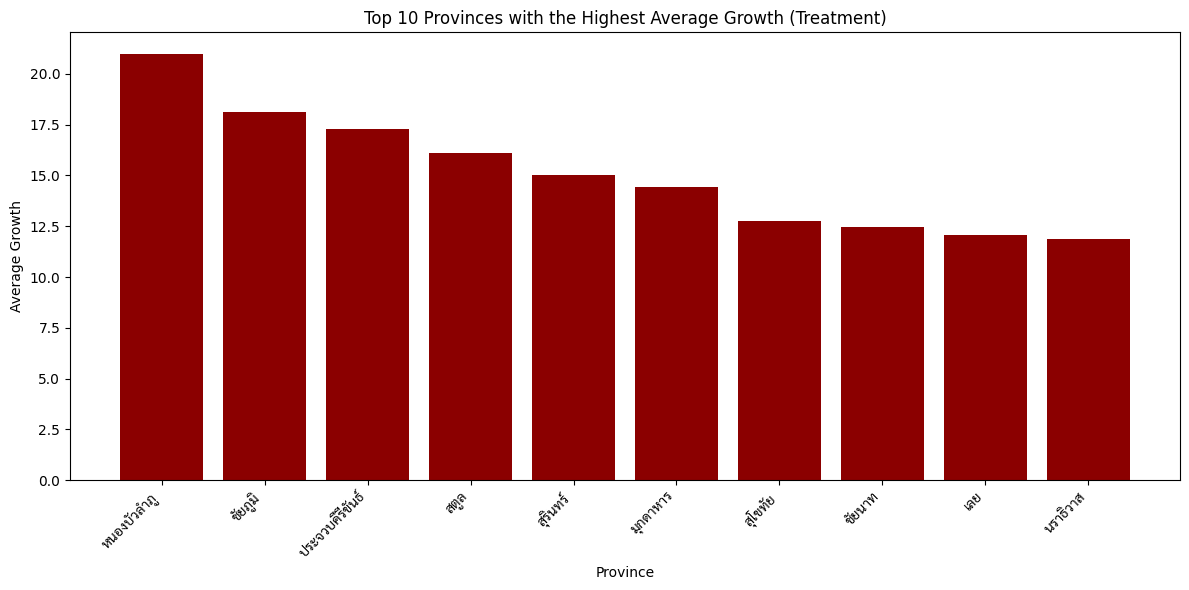

In [ ]:
top_10_provinces = growth_df_treatment.sort_values(by='Average_Growth', ascending=False).head(10)

font_path = '/content/Sarabun-Regular.ttf'
prop = fm.FontProperties(fname=font_path)

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_10_provinces['Province'], top_10_provinces['Average_Growth'], color="darkred")
plt.xlabel('Province')
plt.ylabel('Average Growth')
plt.title('Top 10 Provinces with the Highest Average Growth (Treatment)')
plt.xticks(rotation=45, ha='right', fontproperties=prop, fontsize=10)
plt.tight_layout()
plt.show()

ภาพกราฟแท่งนี้แสดง **Top 10 จังหวัดที่มีอัตราการเติบโตเฉลี่ยสูงสุดในจำนวนผู้เข้ารับการบำบัด (Treatment)** โดยมีรายละเอียดดังนี้:

1. **แกน X (แนวนอน):** ชื่อจังหวัดที่ติดอันดับ 10 จังหวัดที่มีอัตราการเติบโตเฉลี่ยสูงสุด  
2. **แกน Y (แนวตั้ง):** ค่าการเติบโตเฉลี่ย (Average Growth)  

จากกราฟพบว่า:  
- จังหวัดที่มีอัตราการเติบโตเฉลี่ยสูงสุด คือ **หนองบัวลำภู** ซึ่งมีค่าเฉลี่ยการเติบโตสูงกว่า 20  
- รองลงมาคือจังหวัด **ชัยภูมิ** และ **ประจวบคีรีขันธ์** ซึ่งมีค่าเฉลี่ยประมาณ 18 และ 17 ตามลำดับ  
- จังหวัดอื่น ๆ เช่น **สตูล, สุรินทร์, มุกดาหาร**, **สุโขทัย**, **ชัยนาท**, และ**เลย**มีค่าเฉลี่ยการเติบโตลดหลั่นกันลงมา  
- **นราธิวาส** อยู่ในอันดับที่ 10 โดยมีอัตราการเติบโตเฉลี่ยประมาณ 12  

ซึ่งกราฟนี้แสดงให้เห็นว่าจังหวัดต่าง ๆ มีอัตราการเติบโตในการรองรับผู้เข้าบำบัดแตกต่างกัน โดยจังหวัดที่มีอัตราการเติบโตสูงสุด เช่น หนองบัวลำภูและชัยภูมิ อาจสะท้อนถึงการปรับปรุงระบบการบำบัดหรือความต้องการที่เพิ่มขึ้นอย่างมีนัยสำคัญในพื้นที่นั้น ๆ

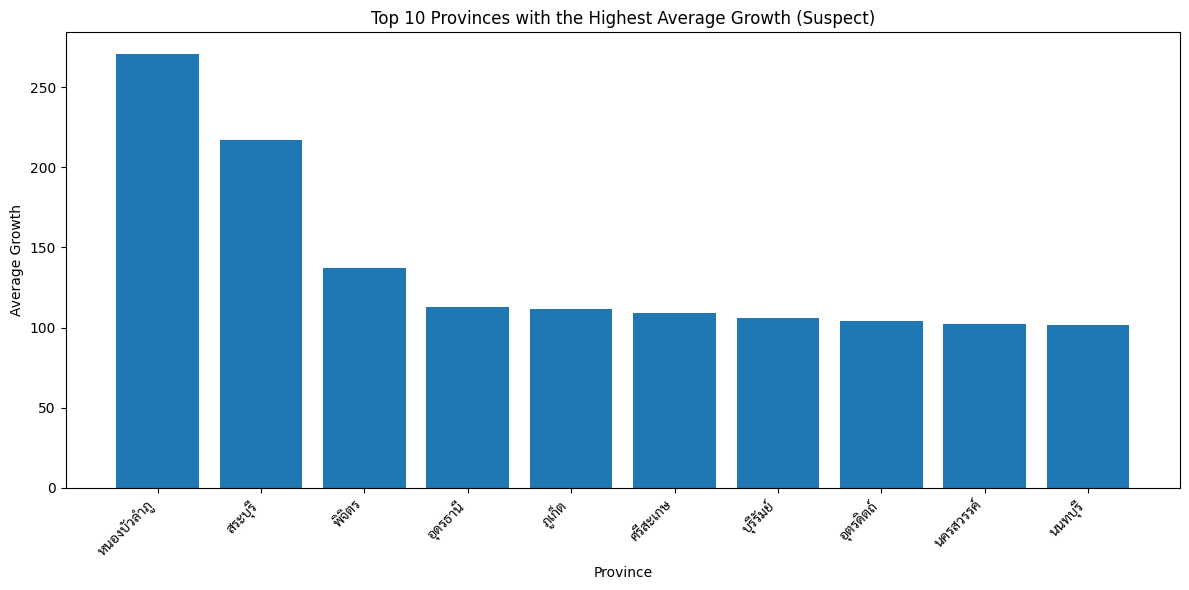

In [ ]:
top_10_provinces = growth_df_suspect.sort_values(by='Average_Growth', ascending=False).head(10)

font_path = '/content/Sarabun-Regular.ttf'
prop = fm.FontProperties(fname=font_path)

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_10_provinces['Province'], top_10_provinces['Average_Growth'])
plt.xlabel('Province')
plt.ylabel('Average Growth')
plt.title('Top 10 Provinces with the Highest Average Growth (Suspect)')
plt.xticks(rotation=45, ha='right', fontproperties=prop, fontsize=10)
plt.tight_layout()
plt.show()

กราฟแท่งนี้แสดง **Top 10 จังหวัดที่มีอัตราการเติบโตเฉลี่ยสูงสุดของจำนวนผู้ต้องหาคดียาเสพติด (Suspect)** โดยมีรายละเอียดดังนี้:

1. **แกน X (แนวนอน):** แกน X (แนวนอน): ชื่อจังหวัดที่ติดอันดับ 10 จังหวัดที่มีอัตราการเติบโตเฉลี่ยสูงสุด
2. **แกน Y (แนวตั้ง):** ค่าเฉลี่ยการเติบโต (Average Growth)  

จากกราฟพบว่า:
- **จังหวัดหนองบัวลำภู** มีอัตราการเติบโตเฉลี่ยสูงสุดอย่างโดดเด่น อยู่ที่ประมาณ **270** ซึ่งสูงกว่าจังหวัดอื่น ๆ อย่างชัดเจน  
- **จังหวัดสระบุรี** ตามมาเป็นอันดับที่สอง โดยมีการเติบโตเฉลี่ยประมาณ **220**  
- จังหวัดในลำดับถัดมา ได้แก่ **พิจิตร, อุดรธานี**, **ภูเก็ต**, **ศรีษะเกษ**, **บุรีรัมย์**, **อุตรดิตถ์**, และ**นคราสวรรค์**โดยมีค่าเฉลี่ยลดหลั่นกันลงมา
- จังหวัดท้ายสุดใน 10 อันดับ คือ **นนทบุรี** ซึ่งมีอัตราการเติบโตเฉลี่ยประมาณ **100**  

กราฟนี้สะท้อนให้เห็นถึงการเพิ่มขึ้นของจำนวนผู้ต้องสงสัยคดียาเสพติดอย่างรวดเร็วในบางจังหวัด โดยเฉพาะ **หนองบัวลำภูและสระบุรี** ซึ่งอาจเป็นผลมาจากปัจจัยต่าง ๆ เช่น การเพิ่มขึ้นของกิจกรรมการค้ายาเสพติด, การขยายตัวของเครือข่ายลักลอบ หรือการปราบปรามและบังคับใช้กฎหมายที่เข้มข้นขึ้นในพื้นที่เหล่านี้  

การวิเคราะห์นี้อาจเป็นจุดเริ่มต้นสำคัญในการวางแผนจัดสรรทรัพยากรและมาตรการป้องกันในพื้นที่ที่มีความเสี่ยงสูงสุดต่อปัญหายาเสพติด

In [ ]:
average_growth_treatment = growth_df_treatment['Average_Growth'].mean()
print(f"Average Growth Rate for All Provinces (Treatment): {average_growth_treatment}")

# Calculate the average of average growth for all provinces for suspect
average_growth_suspect = growth_df_suspect['Average_Growth'].mean()
print(f"Average Growth Rate for All Provinces (Suspect): {average_growth_suspect}")

Average Growth Rate for All Provinces (Treatment): 1.9266021868487107
Average Growth Rate for All Provinces (Suspect): 54.09264084290196


In [ ]:
merged_df.columns = merged_df.columns.astype(str)

In [ ]:
merged_df['2565_suspect'] = round(((merged_df['2564_suspect']*0.54)+merged_df['2564_suspect']), 2)
merged_df['2566_suspect'] = round(((merged_df['2565_suspect']*0.54)+merged_df['2565_suspect']), 2)
merged_df['2567_suspect'] = round(((merged_df['2566_suspect']*0.54)+merged_df['2566_suspect']), 2)
merged_df['2568_suspect'] = round(((merged_df['2567_suspect']*0.54)+merged_df['2567_suspect']), 2)
merged_df['2569_suspect'] = round(((merged_df['2568_suspect']*0.54)+merged_df['2568_suspect']), 2)

In [ ]:
merged_df['2565_treatment'] = round(((merged_df['2564_treatment']*0.19)+merged_df['2564_treatment']), 2)
merged_df['2566_treatment'] = round(((merged_df['2565_treatment']*0.19)+merged_df['2565_treatment']), 2)
merged_df['2567_treatment'] = round(((merged_df['2566_treatment']*0.19)+merged_df['2566_treatment']), 2)
merged_df['2568_treatment'] = round(((merged_df['2567_treatment']*0.19)+merged_df['2567_treatment']), 2)
merged_df['2569_treatment'] = round(((merged_df['2568_treatment']*0.19)+merged_df['2568_treatment']), 2)
merged_df

,ชื่อจังหวัด,2560_suspect,2561_suspect,2562_suspect,2563_suspect,2564_suspect,2560_treatment,2561_treatment,2562_treatment,2563_treatment,...,2565_suspect,2566_suspect,2567_suspect,2568_suspect,2569_suspect,2565_treatment,2566_treatment,2567_treatment,2568_treatment,2569_treatment
0,กระบี่,189,253,500,800,1637,723,1163,1259,980,...,2520.98,3882.31,5978.76,9207.29,14179.23,790.16,940.29,1118.95,1331.55,1584.54
1,กรุงเทพมหานคร,12371,17131,15458,9754,9797,12406,13574,14219,9526,...,15087.38,23234.57,35781.24,55103.11,84858.79,6142.78,7309.91,8698.79,10351.56,12318.36
2,กาญจนบุรี,1412,2227,2092,1309,1246,1876,2501,3089,2573,...,1918.84,2955.01,4550.72,7008.11,10792.49,1771.91,2108.57,2509.20,2985.95,3553.28
3,กาฬสินธุ์,496,681,810,1697,4197,3077,2370,2800,1934,...,6463.38,9953.61,15328.56,23605.98,36353.21,2695.35,3207.47,3816.89,4542.10,5405.10
4,กำแพงเพชร,521,1269,2208,1193,860,1491,1495,1508,1343,...,1324.40,2039.58,3140.95,4837.06,7449.07,1502.97,1788.53,2128.35,2532.74,3013.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,เพชรบุรี,741,1244,1395,1397,1281,1580,1596,1934,1496,...,1972.74,3038.02,4678.55,7204.97,11095.65,1228.08,1461.42,1739.09,2069.52,2462.73
73,เพชรบูรณ์,715,1762,1378,886,2517,2601,2634,3364,3406,...,3876.18,5969.32,9192.75,14156.84,21801.53,3536.68,4208.65,5008.29,5959.87,7092.25
74,เลย,706,867,797,879,2596,1358,1376,1519,1697,...,3997.84,6156.67,9481.27,14601.16,22485.79,2522.80,3002.13,3572.53,4251.31,5059.06
75,แพร่,1619,1843,2015,2105,3069,2105,1919,2081,1895,...,4726.26,7278.44,11208.80,17261.55,26582.79,2272.90,2704.75,3218.65,3830.19,4557.93


In [ ]:
sum_suspect_2565 = merged_df['2565_suspect'].sum()
sum_suspect_2566 = merged_df['2566_suspect'].sum()
sum_suspect_2567 = merged_df['2567_suspect'].sum()
sum_suspect_2568 = merged_df['2568_suspect'].sum()
sum_suspect_2569 = merged_df['2569_suspect'].sum()

# Print the sums
print(f"The sum of suspects from 2565 is: {sum_suspect_2565}")
print(f"The sum of suspects from 2566 is: {sum_suspect_2566}")
print(f"The sum of suspects from 2567 is: {sum_suspect_2567}")
print(f"The sum of suspects from 2568 is: {sum_suspect_2568}")
print(f"The sum of suspects from 2569 is: {sum_suspect_2569}")

The sum of suspects from 2565 is: 363136.62
The sum of suspects from 2566 is: 559230.4199999999
The sum of suspects from 2567 is: 861214.8800000001
The sum of suspects from 2568 is: 1326270.9300000002
The sum of suspects from 2569 is: 2042457.25


**จากสูตร Simple Growth Model ใช้วิธีการดังกล่าวในการคำนวณผลลัพธ์สำหรับแต่ละจังหวัด**
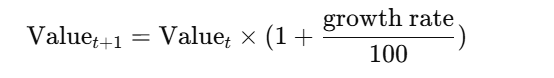

In [ ]:
treatment_provinces = [
    "หนองบัวลำภู", "ชัยภูมิ", "ประจวบคีรีขันธ์", "สตูล", "สุรินทร์",
    "มุกดาหาร", "สุโขทัย", "ชัยนาท", "เลย", "นราธิวาส"
]

def forecast_values(df, average_growth, years_to_forecast=5):
    """Forecasts future values based on average growth rate."""
    forecast_years = []
    for i in range(years_to_forecast):
      year = 2565 + i
      forecast_years.append(str(year))

    last_year_data = df.filter(regex="2564").iloc[:,0].values
    forecasted_values = []
    for value in last_year_data:
      forecasted_year_values = []
      for year in range(years_to_forecast):
        value = value + (value * (average_growth / 100))
        forecasted_year_values.append(int(round(value)))
      forecasted_values.append(forecasted_year_values)

    forecast_df = pd.DataFrame(forecasted_values, columns=forecast_years)
    forecast_df["Province"] = df["Province"]
    return forecast_df


# Forecast treatment
forecast_treatment = forecast_values(growth_df_treatment, average_growth_treatment)
print("Forecasted Treatment:")
forecast_treatment

Forecasted Treatment:


,2565,2566,2567,2568,2569,Province
0,677,690,703,717,730,กระบี่
1,5261,5363,5466,5571,5679,กรุงเทพมหานคร
2,1518,1547,1577,1607,1638,กาญจนบุรี
3,2309,2353,2398,2445,2492,กาฬสินธุ์
4,1287,1312,1337,1363,1389,กำแพงเพชร
...,...,...,...,...,...,...
72,1052,1072,1093,1114,1135,เพชรบุรี
73,3029,3088,3147,3208,3270,เพชรบูรณ์
74,2161,2202,2245,2288,2332,เลย
75,1947,1984,2023,2062,2101,แพร่


In [ ]:
top_10_provinces_suspect = growth_df_suspect.sort_values(by='Average_Growth', ascending=False).head(10)

forecast_suspect = forecast_values(growth_df_suspect, average_growth_suspect)

# Merge forecasted values with the top 10 provinces data
top_10_forecast_suspect = pd.merge(top_10_provinces_suspect, forecast_suspect, on="Province")

# Display the results
print("\nTop 10 Provinces with Highest Average Growth (Suspect) and Forecasted Values (2565-2569):")
top_10_forecast_suspect[['Province','Average_Growth', '2565', '2566', '2567', '2568', '2569']]


Top 10 Provinces with Highest Average Growth (Suspect) and Forecasted Values (2565-2569):


,Province,Average_Growth,2565,2566,2567,2568,2569
0,หนองบัวลำภู,270.660282,1783,2747,4233,6523,10052
1,สระบุรี,216.723229,1737,2676,4124,6354,9791
2,พิจิตร,137.051601,1660,2557,3941,6072,9357
3,อุดรธานี,113.115383,10389,16009,24668,38012,58573
4,ภูเก็ต,111.786079,6247,9626,14833,22857,35220
5,ศรีสะเกษ,109.037220,10389,16009,24668,38012,58573
6,บุรีรัมย์,106.096773,8039,12388,19088,29414,45324
7,อุตรดิตถ์,103.884042,2838,4374,6740,10385,16003
8,นครสวรรค์,101.994922,2341,3607,5558,8564,13197
9,นนทบุรี,101.420636,4946,7622,11745,18098,27888


In [ ]:
# Forecast suspect
forecast_suspect = forecast_values(growth_df_suspect, average_growth_suspect)
print("\nForecasted Suspect:")
forecast_suspect.head(10)


Forecasted Suspect:


,2565,2566,2567,2568,2569,Province
0,2522,3887,5990,9229,14222,กระบี่
1,15096,23263,35846,55236,85114,กรุงเทพมหานคร
2,1920,2959,4559,7025,10825,กาญจนบุรี
3,6467,9966,15356,23663,36463,กาฬสินธุ์
4,1325,2042,3147,4849,7472,กำแพงเพชร
5,12431,19155,29516,45482,70084,ขอนแก่น
6,3446,5309,8181,12607,19426,จันทบุรี
7,6410,9878,15221,23454,36141,ฉะเชิงเทรา
8,11833,18233,28096,43294,66714,ชลบุรี
9,1179,1816,2799,4313,6646,ชัยนาท


In [ ]:
top_10_provinces_treatment = growth_df_treatment.sort_values(by='Average_Growth', ascending=False).head(10)
forecast_treatment = forecast_values(growth_df_treatment, average_growth_treatment)

# Merge forecasted values with the top 10 provinces data
top_10_forecast_treatment = pd.merge(top_10_provinces_treatment, forecast_treatment, on="Province")

# Display the results
print("\nTop 10 Provinces with Highest Average Growth (Treatment) and Forecasted Values (2565-2569):")
top_10_forecast_treatment[['Province','Average_Growth', '2565', '2566', '2567', '2568', '2569']]


Top 10 Provinces with Highest Average Growth (Treatment) and Forecasted Values (2565-2569):


,Province,Average_Growth,2565,2566,2567,2568,2569
0,หนองบัวลำภู,20.995518,1144,1166,1188,1211,1234
1,ชัยภูมิ,18.116504,3727,3799,3872,3947,4023
2,ประจวบคีรีขันธ์,17.276060,1179,1202,1225,1249,1273
3,สตูล,16.092497,1191,1213,1237,1261,1285
4,สุรินทร์,15.044748,2833,2887,2943,2999,3057
5,มุกดาหาร,14.447300,2905,2961,3018,3076,3135
6,สุโขทัย,12.754232,1679,1711,1744,1778,1812
7,ชัยนาท,12.471559,800,816,831,847,864
8,เลย,12.090624,2161,2202,2245,2288,2332
9,นราธิวาส,11.861911,1580,1610,1641,1673,1705


# **Exploratory Data Analysis Univ BivMulti PLot**

**Import dataset**

In [ ]:
weight_drug = pd.read_excel('/content/คลีนน้ำหนักของกลางยาเสพติด จำแนกตามชนิดย.xlsx')
weight_drug

,จังหวัด,ชนิดยาเสพติด,2554,2555,2556,2557,2558,2559,2560,2561,2562,2563,2564
0,กรุงเทพมหานคร,เฮโรอีน,16.82000,39.5600,319.06,3.730,9.64,48.27,12.33,110.58,122.56,103.32,693.80
1,กรุงเทพมหานคร,เอ็กซ์ตาซี,2.94000,0.9500,3.13,1.680,2.95,21.17,17.76,16.20,14.68,96.13,3.01
2,กรุงเทพมหานคร,กัญชาแห้ง,350.49000,164.2800,127.07,106.870,958.92,2970.62,1667.14,797.44,691.47,1302.39,2738.54
3,กรุงเทพมหานคร,พืชกระท่อม,298.85623,723.1900,985.58,559.080,77.04,1675.44,341.14,181.60,586.73,831.93,372.36
4,กรุงเทพมหานคร,เมทแอมเฟตามีน,605.67885,1105.2500,1256.24,442.300,1237.41,1082.91,3671.36,3845.14,3091.96,838.24,1900.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,นราธิวาส,โคคาอีน (โคเคน),0.05050,0.0050,0.00,0.000,0.01,0.00,0.00,0.00,0.00,0.00,0.00
691,นราธิวาส,คีตามีน,0.06700,0.0001,0.00,0.004,0.01,0.00,0.00,0.00,0.00,1.02,0.00
692,นราธิวาส,โคเดอีน,0.00000,14.3000,0.00,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00
693,หมายเหตุ: ปี 2561 - 2562 และ 2564 เอ็คซ์ตาซี แ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
weight_drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   จังหวัด       695 non-null    object 
 1   ชนิดยาเสพติด  693 non-null    object 
 2   2554          693 non-null    float64
 3   2555          693 non-null    float64
 4   2556          693 non-null    float64
 5   2557          693 non-null    float64
 6   2558          693 non-null    float64
 7   2559          693 non-null    float64
 8   2560          693 non-null    float64
 9   2561          693 non-null    float64
 10  2562          693 non-null    float64
 11  2563          691 non-null    float64
 12  2564          693 non-null    float64
dtypes: float64(11), object(2)
memory usage: 70.7+ KB


In [ ]:
weight_drug = weight_drug.drop(index=list(range(693, 695)))
weight_drug

,จังหวัด,ชนิดยาเสพติด,2554,2555,2556,2557,2558,2559,2560,2561,2562,2563,2564
0,กรุงเทพมหานคร,เฮโรอีน,16.82000,39.5600,319.06,3.730,9.64,48.27,12.33,110.58,122.56,103.32,693.80
1,กรุงเทพมหานคร,เอ็กซ์ตาซี,2.94000,0.9500,3.13,1.680,2.95,21.17,17.76,16.20,14.68,96.13,3.01
2,กรุงเทพมหานคร,กัญชาแห้ง,350.49000,164.2800,127.07,106.870,958.92,2970.62,1667.14,797.44,691.47,1302.39,2738.54
3,กรุงเทพมหานคร,พืชกระท่อม,298.85623,723.1900,985.58,559.080,77.04,1675.44,341.14,181.60,586.73,831.93,372.36
4,กรุงเทพมหานคร,เมทแอมเฟตามีน,605.67885,1105.2500,1256.24,442.300,1237.41,1082.91,3671.36,3845.14,3091.96,838.24,1900.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,นราธิวาส,เมทแอมเฟตามีน,48.92369,43.6300,32.64,24.630,99.31,46.00,103.05,181.02,363.37,0.40,230.17
689,นราธิวาส,ไอซ์,0.63631,8.3200,0.53,0.900,2.12,0.67,1190.00,139.01,98.12,2599.03,753.38
690,นราธิวาส,โคคาอีน (โคเคน),0.05050,0.0050,0.00,0.000,0.01,0.00,0.00,0.00,0.00,0.00,0.00
691,นราธิวาส,คีตามีน,0.06700,0.0001,0.00,0.004,0.01,0.00,0.00,0.00,0.00,1.02,0.00


In [ ]:
weight_drug = weight_drug.rename(columns={'จังหวัด': 'Province','ชนิดยาเสพติด': 'drug_type'})
weight_drug

,Province,drug_type,2554,2555,2556,2557,2558,2559,2560,2561,2562,2563,2564
0,กรุงเทพมหานคร,เฮโรอีน,16.82000,39.5600,319.06,3.730,9.64,48.27,12.33,110.58,122.56,103.32,693.80
1,กรุงเทพมหานคร,เอ็กซ์ตาซี,2.94000,0.9500,3.13,1.680,2.95,21.17,17.76,16.20,14.68,96.13,3.01
2,กรุงเทพมหานคร,กัญชาแห้ง,350.49000,164.2800,127.07,106.870,958.92,2970.62,1667.14,797.44,691.47,1302.39,2738.54
3,กรุงเทพมหานคร,พืชกระท่อม,298.85623,723.1900,985.58,559.080,77.04,1675.44,341.14,181.60,586.73,831.93,372.36
4,กรุงเทพมหานคร,เมทแอมเฟตามีน,605.67885,1105.2500,1256.24,442.300,1237.41,1082.91,3671.36,3845.14,3091.96,838.24,1900.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,นราธิวาส,เมทแอมเฟตามีน,48.92369,43.6300,32.64,24.630,99.31,46.00,103.05,181.02,363.37,0.40,230.17
689,นราธิวาส,ไอซ์,0.63631,8.3200,0.53,0.900,2.12,0.67,1190.00,139.01,98.12,2599.03,753.38
690,นราธิวาส,โคคาอีน (โคเคน),0.05050,0.0050,0.00,0.000,0.01,0.00,0.00,0.00,0.00,0.00,0.00
691,นราธิวาส,คีตามีน,0.06700,0.0001,0.00,0.004,0.01,0.00,0.00,0.00,0.00,1.02,0.00


**Rename each drugs name**

In [ ]:
heroin = 'เฮโรอีน'
ecstasy = 'เอ็กซ์ตาซี'
dried_cannabis = 'กัญชาแห้ง'
kratom = 'พืชกระท่อม'
methamphetamine = 'เมทแอมเฟตามีน'
ice = 'ไอซ์'
coca = 'โคคาอีน (โคเคน)'
ketamine = 'คีตามีน'
codeine = 'โคเดอีน'

## **The number of suspect arrests from 2554-2564**

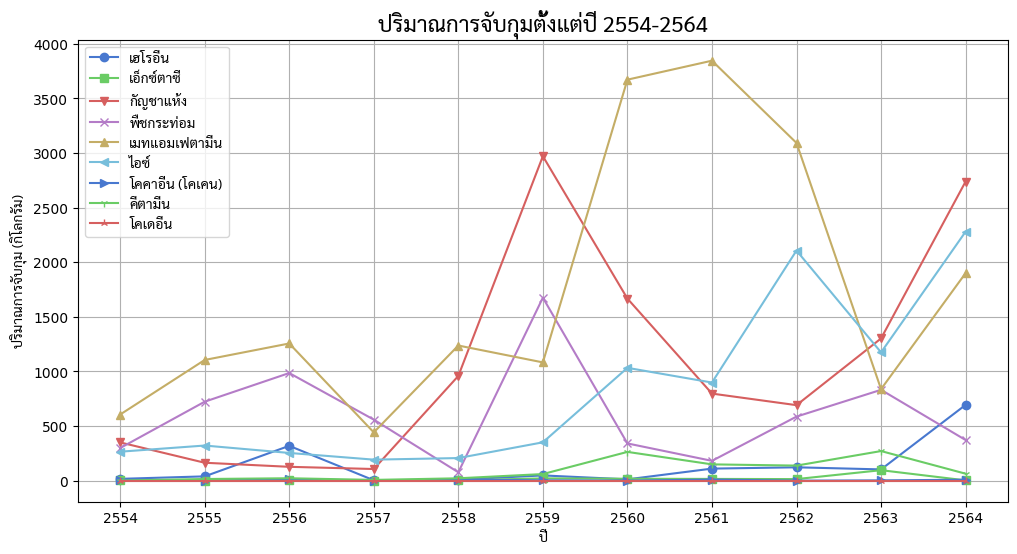

In [ ]:
df_heroin = weight_drug[weight_drug['drug_type'] == heroin]
df_ecstasy = weight_drug[weight_drug['drug_type'] == ecstasy]
df_dried_cannabis = weight_drug[weight_drug['drug_type'] == dried_cannabis]
df_kratom = weight_drug[weight_drug['drug_type'] == kratom]
df_methamphetamine = weight_drug[weight_drug['drug_type'] == methamphetamine]
df_ice = weight_drug[weight_drug['drug_type'] == ice]
df_coca = weight_drug[weight_drug['drug_type'] == coca]
df_ketamine = weight_drug[weight_drug['drug_type'] == ketamine]
df_codeine = weight_drug[weight_drug['drug_type'] == codeine]

plt.figure(figsize=(12, 6))

plt.plot(df_heroin.columns[2:], df_heroin.iloc[0, 2:], marker='o', label=heroin)
plt.plot(df_ecstasy.columns[2:], df_ecstasy.iloc[0, 2:], marker='s', label=ecstasy)
plt.plot(df_dried_cannabis.columns[2:], df_dried_cannabis.iloc[0, 2:], marker='v', label=dried_cannabis)
plt.plot(df_kratom.columns[2:], df_kratom.iloc[0, 2:], marker='x', label=kratom)
plt.plot(df_methamphetamine.columns[2:], df_methamphetamine.iloc[0, 2:], marker='^', label=methamphetamine)
plt.plot(df_ice.columns[2:], df_ice.iloc[0, 2:], marker='<', label=ice)
plt.plot(df_coca.columns[2:], df_coca.iloc[0, 2:], marker='>', label=coca)
plt.plot(df_ketamine.columns[2:], df_ketamine.iloc[0, 2:], marker='1', label=ketamine)
plt.plot(df_ketamine.columns[2:], df_codeine.iloc[0, 2:], marker='2', label=codeine)

plt.xlabel('ปี', fontproperties=prop)
plt.ylabel('ปริมาณการจับกุม (กิโลกรัม)', fontproperties=prop)
plt.title('ปริมาณการจับกุมตั้งแต่ปี 2554-2564'.format(heroin, ecstasy), fontproperties=prop, fontsize=16)
plt.legend(prop=prop)
plt.grid(True)

plt.show()

กราฟนี้แสดง **ปริมาณการจับกุมยาเสพติดแต่ละชนิด** ระหว่างปี **2554-2564** (10 ปี) โดยมีรายละเอียดดังนี้:
1. แกนต่าง ๆ:
- **แกนนอน (X):** ปี พ.ศ. (2554-2564)
- **แกนตั้ง (Y):** ปริมาณการจับกุมยาเสพติด (คิดเป็นกิโลกรัม)
---
2. ชนิดของยาเสพติด:
ข้อมูลแบ่งตามเส้นสีต่าง ๆ โดยยาเสพติดที่ถูกจับกุมมากที่สุดบางช่วงประกอบด้วย:
- **แมทแอมเฟตามีน (เส้นสีม่วง):**  
   - มีปริมาณการจับกุมพุ่งสูงสุดในช่วงปี **2560-2561** โดยแตะระดับเกือบ **4,000 กิโลกรัม** ก่อนจะลดลงอย่างรวดเร็วในปี **2563**  
- **กัญชาแห้ง (เส้นสีเขียว):**  
   - ปริมาณการจับกุมเพิ่มสูงขึ้นอย่างชัดเจนในปี **2559** (ประมาณ **3,000 กิโลกรัม**) และเพิ่มขึ้นอีกครั้งในปี **2564**  
- **ไอซ์ (เส้นสีน้ำตาล):**  
   - ปริมาณการจับกุมเพิ่มขึ้นในช่วงปี **2562** และพุ่งสูงในปี **2564** โดยมีค่าประมาณ **2,500 กิโลกรัม**  
- **พืชกระท่อม (เส้นสีแดง):**  
   - มีการจับกุมที่สูงในปี **2559** และเพิ่มขึ้นอีกครั้งในปี **2563-2564**
---
3. แนวโน้มที่สำคัญ:
- ยาเสพติดบางชนิด เช่น **แมทแอมเฟตามีน** และ **กัญชาแห้ง** แสดงแนวโน้มการจับกุมที่ผันผวนอย่างมาก แต่ยังคงมีปริมาณสูงในบางช่วง  
- ยาอื่น ๆ เช่น **เอโรอีน, เอ็กซ์ตาซี และโคเคน** มีปริมาณการจับกุมค่อนข้างต่ำเมื่อเทียบกับชนิดอื่น ๆ  
- ปี **2564** มีการเพิ่มขึ้นอย่างชัดเจนของ **กัญชาแห้ง, ไอซ์ และแมทแอมเฟตามีน**


กราฟนี้สะท้อนถึงแนวโน้มการเปลี่ยนแปลงในปัญหายาเสพติดในประเทศไทยตลอด 10 ปีที่ผ่านมา โดยเฉพาะยาเสพติดหลักอย่าง **แมทแอมเฟตามีน** และ **กัญชาแห้ง** ที่มีปริมาณการจับกุมสูงในบางช่วงเวลา ซึ่งอาจเป็นผลมาจากการแพร่ระบาดของยาเสพติด, การปราบปรามที่เข้มข้น หรือการขยายตัวของตลาดยาเสพติดในช่วงเวลานั้น ๆ

## **The top 10 provinces based on the percentage distribution of suspects**

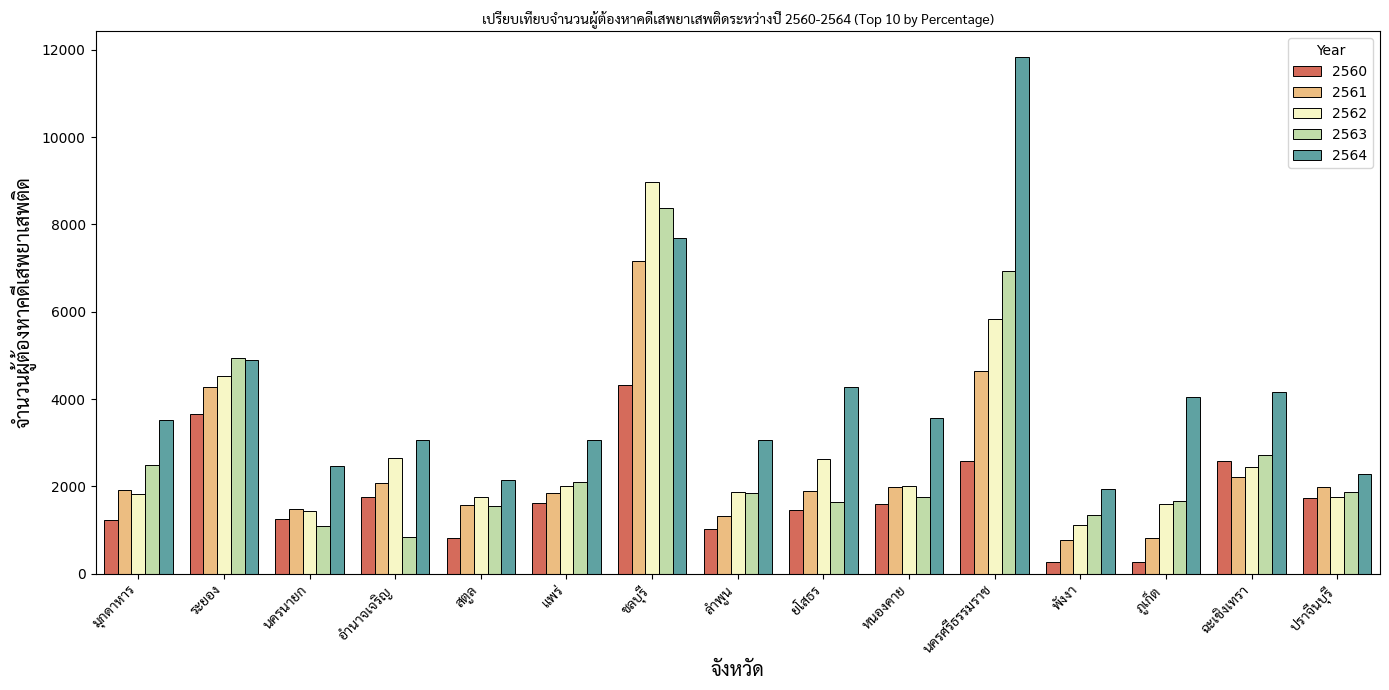

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

font_path = '/content/Sarabun-Regular.ttf'
prop = fm.FontProperties(fname=font_path)

df_suspect = pd.read_excel('จำนวนผู้ต้องหาคดีเสพยาเสพติด ปี 60-64.xlsx')
population_df = pd.read_excel('จำนวนประชากรทุกจังหวัด ปี 2560-2564.xlsx')

df_suspect.columns = ['ชื่อจังหวัด', '2560', '2561', '2562', '2563', '2564']
population_df.columns = ['ชื่อจังหวัด', '2560', '2561', '2562', '2563', '2564']

merged_df = pd.merge(df_suspect, population_df, on='ชื่อจังหวัด', how='left')
merged_df['Total Cases'] = merged_df[['2560_x', '2561_x', '2562_x', '2563_x', '2564_x']].mean(axis=1)
merged_df['Population'] = merged_df[['2560_y', '2561_y', '2562_y', '2563_y', '2564_y']].mean(axis=1)
merged_df['Percentage'] = (merged_df['Total Cases'] / merged_df['Population']) * 100
top_10_percentage = merged_df.sort_values(by='Percentage', ascending=False).head(15)

melted_df = top_10_percentage.melt(id_vars=['ชื่อจังหวัด'],
                                    value_vars=['2560_x', '2561_x', '2562_x', '2563_x', '2564_x'],
                                    var_name='Year',
                                    value_name='Cases')

melted_df['Year'] = melted_df['Year'].str.replace('_x', '', regex=False)

plt.figure(figsize=(14, 7), )
sns.barplot(x='ชื่อจังหวัด', y='Cases', hue='Year', data=melted_df, palette='Spectral', edgecolor='black', linewidth=0.7)

plt.xticks(rotation=90)
plt.xlabel('จังหวัด', fontsize=14, fontweight='bold', fontproperties=prop)
plt.ylabel('จำนวนผู้ต้องหาคดีเสพยาเสพติด', fontsize=14, fontweight='bold', fontproperties=prop)
plt.title('เปรียบเทียบจำนวนผู้ต้องหาคดีเสพยาเสพติดระหว่างปี 2560-2564 (Top 10 by Percentage)',
          fontsize=20, fontweight='bold', fontproperties=prop)


plt.style.use('seaborn-v0_8-muted')
plt.xticks(rotation=45, ha="right", fontproperties=prop)
plt.tight_layout()
plt.show()

ภาพนี้แสดง **จำนวนผู้ต้องหาคดีเสพยาเสพติดใน 15 จังหวัดที่มีสัดส่วนผู้ต้องหาสูงสุด** เมื่อเทียบกับจำนวนประชากร ระหว่างปี **2560-2564** โดยแต่ละจังหวัดถูกเปรียบเทียบจำนวนผู้ต้องหาในแต่ละปี ผ่านกราฟแท่งที่มีสีต่างกัน

---

**อธิบายองค์ประกอบในภาพ:**
1. **แกนตั้ง (Y-axis):** จำนวนผู้ต้องหาคดีเสพยาเสพติด (จำนวนคน)
2. **แกนนอน (X-axis):** รายชื่อ 15 จังหวัดที่มีสัดส่วนผู้ต้องหาต่อประชากรสูงสุด
3. **สีของแท่งกราฟ:** แทนปีต่าง ๆ ระหว่าง **2560-2564**
   - สีที่แตกต่างกันช่วยให้เห็นการเปลี่ยนแปลงจำนวนผู้ต้องหาในแต่ละปีอย่างชัดเจน

---

**การสังเกตข้อมูลจากภาพ:**

**จังหวัดที่โดดเด่น:**
   - **นครศรีธรรมราช** และ **ชลบุรี** มีจำนวนผู้ต้องหาสูงกว่าจังหวัดอื่น ๆ อย่างชัดเจน โดยเฉพาะในปี **2563 และ 2564** แสดงให้เห็นถึงปัญหายาเสพติดรุนแรง โดยวัดจากจำนวนผู้ต้องหาที่ถูกจับกุมในแต่ละปี และยังเผยให้เห็นว่าปัญหานี้มีแนวโน้มเพิ่มขึ้นอย่างต่อเนื่องในช่วงปีหลัง ๆ ซึ่งควรให้ความสำคัญและหาแนวทางแก้ไขอย่างเร่งด่วน

## **A comparison of suspects in 2563 and 2564**

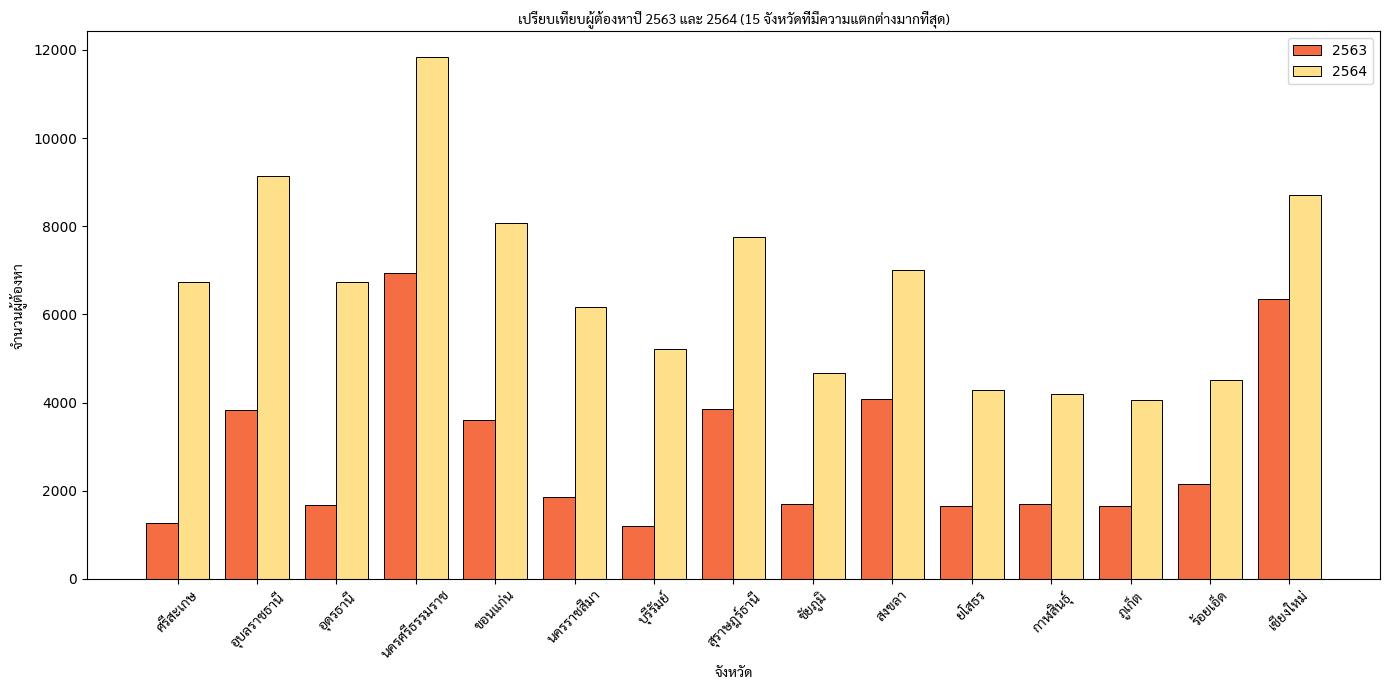

In [ ]:
df_suspect = pd.read_excel('จำนวนผู้ต้องหาคดีเสพยาเสพติด ปี 60-64.xlsx')
df_suspect.columns = ['ชื่อจังหวัด', '2560', '2561', '2562', '2563', '2564']

df_suspect['Difference'] = df_suspect['2564'] - df_suspect['2563']

top_15_provinces = df_suspect.sort_values(by='Difference', ascending=False).head(15)

font_path = '/content/Sarabun-Regular.ttf'
prop = fm.FontProperties(fname=font_path)
plt.figure(figsize=(14, 7))

X_axis = np.arange(len(top_15_provinces))

plt.bar(X_axis - 0.2, top_15_provinces['2563'], 0.4, label='2563', color= '#f46d43', edgecolor= 'black', linewidth=0.7)
plt.bar(X_axis + 0.2, top_15_provinces['2564'], 0.4, label='2564', color= '#fee08b', edgecolor= 'black', linewidth=0.7)

plt.xticks(X_axis, top_15_provinces['ชื่อจังหวัด'], rotation=45, fontproperties=prop)

plt.xlabel('จังหวัด', fontproperties=prop)
plt.ylabel('จำนวนผู้ต้องหา', fontproperties=prop)
plt.title('เปรียบเทียบผู้ต้องหาปี 2563 และ 2564 (15 จังหวัดที่มีความแตกต่างมากที่สุด)', fontproperties=prop)
plt.legend()
plt.tight_layout()
plt.show()

ภาพนี้แสดง **การเปรียบเทียบจำนวนผู้ต้องหาคดีเสพยาเสพติดระหว่างปี 2563 และ 2564** ใน **15 จังหวัด** ที่มีความแตกต่างของจำนวนผู้ต้องหามากที่สุด โดยใช้กราฟแท่งสองสีเพื่อแสดงความเปลี่ยนแปลงระหว่างสองปี

---

**องค์ประกอบสำคัญในภาพ:**
1. **แกนตั้ง (Y-axis):** จำนวนผู้ต้องหาคดีเสพยาเสพติด (จำนวนคน)
2. **แกนนอน (X-axis):** รายชื่อ 15 จังหวัดที่มีความแตกต่างมากที่สุด
3. **สีของกราฟแท่ง:**
   - สีส้ม แทนปี **2563**
   - สีเหลือง แทนปี **2564**
4. **ตำแหน่งของแท่งกราฟ:** แท่งของปี 2563 จะอยู่ทางซ้าย และปี 2564 จะอยู่ทางขวา

---

**การสังเกตข้อมูลจากภาพ:**
1. **จังหวัดที่มีจำนวนผู้ต้องหาเพิ่มขึ้นมากที่สุดในปี 2564:**
   - จังหวัด **นครศรีธรรมราช** มีจำนวนผู้ต้องหามากที่สุดในปี 2564
   - จังหวัด **อุบลราชธานี** และ **อุดรธานี** ก็มีจำนวนผู้ต้องหาเพิ่มขึ้นอย่างมากเช่นกัน

2. **จังหวัดที่มีความแตกต่างเด่นชัด:**
   - จังหวัดอย่าง **ศรีสะเกษ, อุบลราชธานี, และ อุดรธานี** เป็นตัวอย่างของพื้นที่ที่มีจำนวนผู้ต้องหาเพิ่มขึ้นอย่างมากในปี 2564

---

**ข้อสรุป:**

ภาพนี้สะท้อนให้เห็นถึงการเพิ่มขึ้นของจำนวนผู้ต้องหาคดีเสพยาเสพติดในปี **2564** เมื่อเทียบกับปี **2563** โดยเฉพาะใน 15 จังหวัดที่มีความแตกต่างมากที่สุด ซึ่งบ่งชี้ถึงความรุนแรงและการแพร่ระบาดของปัญหายาเสพติดที่มากขึ้นในบางพื้นที่ **การเพิ่มขึ้นอย่างก้าวกระโดดในบางจังหวัดจำเป็นต้องได้รับการแก้ไขอย่างเร่งด่วน** ผ่านมาตรการที่เข้มงวดและการบำบัดรักษาผู้ติดยาเสพติดอย่างมีประสิทธิภาพ